<a href="https://colab.research.google.com/github/hinton024/Assignment-2-Social-media-and-network-analytics/blob/main/Reddit_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download necessary libraries

In [1]:
!pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


### Importing the Necessary Libraries

In [2]:
import pandas as pd
import re
import json
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re
import nltk
from langdetect import detect, LangDetectException
import contractions
from collections import Counter

C:\Users\Saurabh Sharma\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### 1. Data Preprocessing
#### Loading the Data

In [3]:
# List of NLTK data packages to download
nltk_packages = ['punkt', 'wordnet', 'stopwords']

# Download each package
for package in nltk_packages:
    nltk.download(package)

[nltk_data] Downloading package punkt to C:\Users\Saurabh
[nltk_data]     Sharma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Saurabh
[nltk_data]     Sharma\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Saurabh
[nltk_data]     Sharma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
with open('DB_reddit.json', 'r', encoding='utf-8') as file:
    reddit = json.load(file)

# Converting the data into a DataFrame
df = pd.DataFrame(reddit)
df.head()

,title,score,date,url,num_comments,comments
0,Not under David Beckhams watch,65534,2023-10-06 17:16:05,https://v.redd.it/0mmzjpgdyisb1,2042,"[Please report rule breaking posts, such as:\n..."
1,David Beckham is not letting this go...,29482,2024-01-02 14:44:45,https://i.redd.it/dowdawvo7y9c1.jpeg,982,[Welcome to r/popculturechat! ☺️\n\nAs a proud...
2,David and Victoria Beckham finally addressing ...,800,2023-10-05 20:46:41,https://v.redd.it/ahnysog1vcsb1,261,[I think if they hadn’t brought this up in a d...
3,Victoria Beckham shares photo of husband David...,2687,2023-12-16 10:45:59,https://i.redd.it/nd35a08lpj6c1.jpeg,298,[Welcome to r/popculturechat! ☺️\n\nAs a proud...
4,Micah Richards on David Beckham,5650,2024-09-19 18:27:36,https://v.redd.it/7o6n7df28qpd1,256,[**Mirrors / Alternative Angles**\n \n\n*I am...


#### Check for Missing Values

In [5]:
# Checking for missing values in the dataset
missing_values = df.isnull().sum()

# Display missing values
print("\nMissing Values:")
print(missing_values)


Missing Values:
title           0
score           0
date            0
url             0
num_comments    0
comments        0
dtype: int64


#### Check for Duplicate Values

In [6]:
duplicates = df.duplicated(subset=['url']).sum()
print(f"Number of duplicate rows: {duplicates}")
df.drop_duplicates(subset=['url'], inplace=True)

Number of duplicate rows: 0


#### Advance Preprocessing

In [7]:
# Regular expression pattern for detecting URLs
url_pattern = r'http\S+|www\S+|https\S+'

# Function to check for URLs in text
def contains_url(text):
    return bool(re.search(url_pattern, text))

# Check for URLs in the 'title' column
df['Title_Contains_URL'] = df['title'].apply(contains_url)

# Check for URLs in the 'comments' column (handling multiple comments in each row)
df['Comments_Contain_URL'] = df['comments'].apply(lambda comments: any(contains_url(comment) for comment in comments))

# Display rows where URLs are found in either title or comments
urls_in_data = df[(df['Title_Contains_URL']) | (df['Comments_Contain_URL'])]

# Display the results
print(f"Total rows with URLs in title: {df['Title_Contains_URL'].sum()}")
print(f"Total rows with URLs in comments: {df['Comments_Contain_URL'].sum()}")

# Optionally, display the rows that contain URLs
if not urls_in_data.empty:
    print("\nRows containing URLs:")
    print(urls_in_data[['title', 'comments']].head())
else:
    print("\nNo URLs found in the dataset.")

Total rows with URLs in title: 0
Total rows with URLs in comments: 81

Rows containing URLs:
                                               title  \
0                     Not under David Beckhams watch   
1            David Beckham is not letting this go...   
2  David and Victoria Beckham finally addressing ...   
3  Victoria Beckham shares photo of husband David...   
4                    Micah Richards on David Beckham   

                                            comments  
0  [Please report rule breaking posts, such as:\n...  
1  [Welcome to r/popculturechat! ☺️\n\nAs a proud...  
2  [I think if they hadn’t brought this up in a d...  
3  [Welcome to r/popculturechat! ☺️\n\nAs a proud...  
4  [**Mirrors / Alternative Angles**\n  \n\n*I am...  


In [8]:
# Function to clean text (already removing URLs)
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove special characters
    text = re.sub(r"[^a-zA-Z0-9'\s]", '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Reapply the cleaning function to comments with URLs
df['Cleaned_Comments'] = df['comments'].apply(lambda comments: [clean_text(comment) for comment in comments])

# Verify the removal of URLs by checking the updated comments
urls_in_comments_after_removal = df['Cleaned_Comments'].apply(lambda comments: any(re.search(url_pattern, comment) for comment in comments)).sum()
print(f"Total rows with URLs in comments after removal: {urls_in_comments_after_removal}")


# Function to detect if the text is in English
def is_english(text):
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False

# Function to expand contractions
def expand_contractions(text):
    return contractions.fix(text)

Total rows with URLs in comments after removal: 0


In [9]:
# Cleaning and preprocess titles
df['Cleaned_Title'] = df['title'].apply(lambda x: expand_contractions(clean_text(str(x))) if is_english(str(x)) else '')

# Preprocessing each comment within the list
df['Cleaned_Comments'] = df['comments'].apply(lambda comments: [expand_contractions(clean_text(comment)) for comment in comments if is_english(comment)])

#### Stopwords Removal

In [10]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def process_tokens(tokens):
    # Remove stopwords and lemmatize
    tokens = [word for word in tokens if word not in stop_words]
    # If no tokens are left after stopword removal, return the original tokens
    if not tokens:
        return tokens
    return [lemmatizer.lemmatize(word) for word in tokens]

#### Tokenization and Lemmatization

In [11]:
# Tokenize and lemmatize the cleaned text
df['Title_Tokens'] = df['Cleaned_Title'].apply(lambda x: process_tokens(word_tokenize(x)))
df['Comments_Tokens'] = df['Cleaned_Comments'].apply(lambda comments: [process_tokens(word_tokenize(comment)) for comment in comments])

In [12]:
# Display the processed data
processed_columns = ['title', 'Cleaned_Title', 'Title_Tokens', 'comments', 'Cleaned_Comments', 'Comments_Tokens']
print("\nProcessed Data:")
print(df[processed_columns].head(10))


Processed Data:
                                               title  \
0                     Not under David Beckhams watch   
1            David Beckham is not letting this go...   
2  David and Victoria Beckham finally addressing ...   
3  Victoria Beckham shares photo of husband David...   
4                    Micah Richards on David Beckham   
5                                Young David Beckham   
6                         Thoughts on David Beckham?   
7  david beckham: then vs now – is it just me or ...   
8                          David Beckham is autistic   
9  David and Victoria Beckham recreate their wedd...   

                                       Cleaned_Title  \
0                                                      
1               david beckham is not letting this go   
2  david and victoria beckham finally addressing ...   
3  victoria beckham shares photo of husband david...   
4                    micah richards on david beckham   
5                             

#### Term Frequency

In [13]:
lemmatizer = WordNetLemmatizer()
stopwords_set = set(stopwords.words('english'))

def process_text(text, lemmatizer, stopwords_set):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords_set]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

term_freq_counter = Counter()

# Processing each row in the DataFrame and updating term frequency counts
for _, row in df.iterrows():
    tokens_title = process_text(row['Cleaned_Title'], lemmatizer, stopwords_set)
    tokens_comments = [word for comment in row['Cleaned_Comments'] for word in process_text(comment, lemmatizer, stopwords_set)]

    # Updating term frequency counts
    term_freq_counter.update(tokens_title)
    term_freq_counter.update(tokens_comments)

# Displaying the most common terms
freq_num = 50
print(f"Top {freq_num} most common terms:")
for term, count in term_freq_counter.most_common(freq_num):
    print(f"{term}: {count}")

Top 50 most common terms:
like: 2630
would: 1825
people: 1740
think: 1395
one: 1358
know: 1190
look: 1127
class: 1110
get: 1089
beckham: 1073
time: 1000
even: 913
really: 912
david: 851
good: 839
also: 823
make: 805
year: 798
thing: 780
much: 771
love: 721
still: 704
way: 697
's: 678
never: 671
could: 670
see: 623
working: 618
well: 612
going: 604
money: 598
say: 578
lol: 563
always: 563
got: 560
go: 550
lot: 543
want: 529
right: 516
victoria: 510
work: 510
someone: 507
mean: 506
u: 503
woman: 467
said: 460
man: 459
back: 454
made: 448
though: 444


# WordCloud of Sentiment Heavy Words and Entities

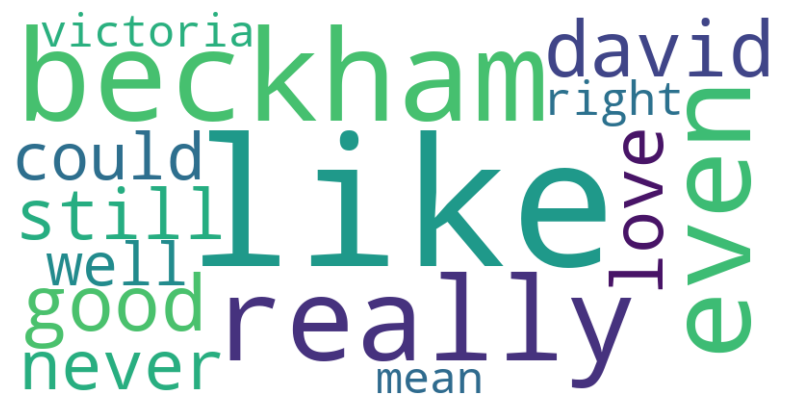

In [14]:
# Visualizing the sentiment heavy words and entities by WordCloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Dictionary with sentiment heavy words and entities and their frequencies as values
words_freq = {
    "like": 2627,
    "beckham": 1077,
    "really": 912,
    "even": 911,
    "good": 844,
    "david": 848,
    "love": 720,
    "still": 702,
    "never": 671,
    "could": 669,
    "well": 614,
    "right": 517,
    "victoria": 512,
    "mean": 504
}


# Generating the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words_freq)

# Plotting the word cloud
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hiding axes
plt.show()


# Bar Chart of Sentiment Heavy Words and Entities with their frequencies

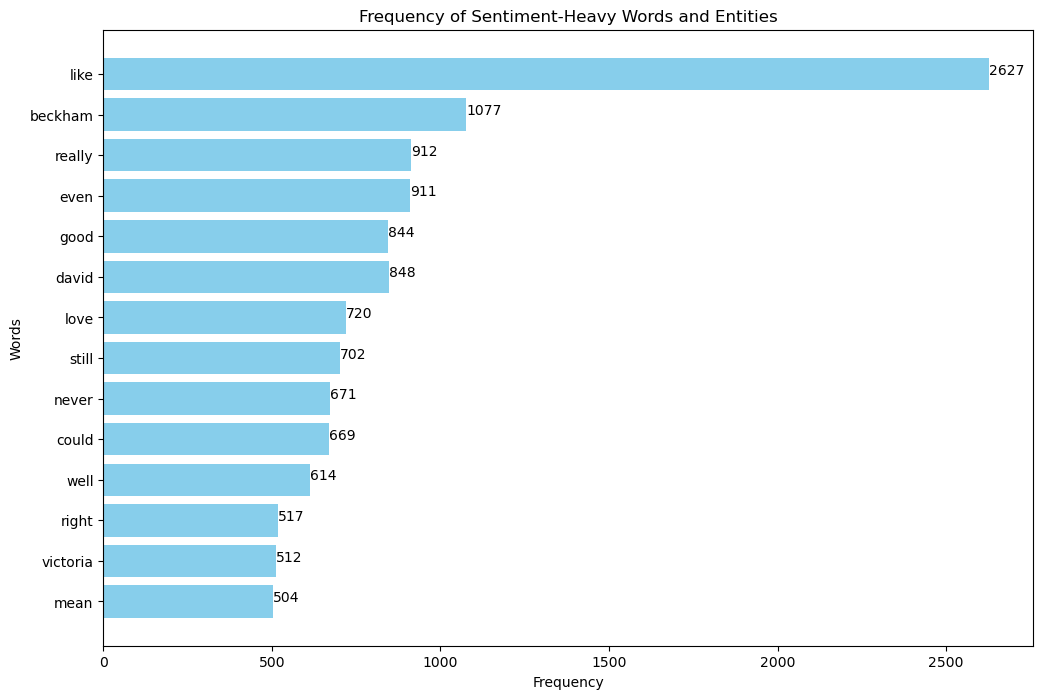

In [15]:
# Visualizing the sentiment heavy words and entities and their frequencies as values

# List of words and their frequencies
words = [
    'like', 'beckham', 'really', 'even', 'good', 'david', 'love',
    'still', 'never', 'could', 'well', 'right', 'victoria', 'mean'
]

frequencies = [
    2627, 1077, 912, 911, 844, 848, 720,
    702, 671, 669, 614, 517, 512, 504
]


# Plotting the bar chart
plt.figure(figsize=(12,8))
plt.barh(words, frequencies, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Frequency of Sentiment-Heavy Words and Entities')
plt.gca().invert_yaxis()  # Inverting y axis to have the most frequent word on top

# Adding frequencies next to the bars  # Adding frequencies next to the bar
for index, value in enumerate(frequencies):
    plt.text(value, index, str(value))
plt.show()


# Tfidf Vectorization

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Function for Pre-processing text by removing numbers
def preprocess_text(text):
    return re.sub(r'\d+', '', text)

# loading data from json file
with open('DB_reddit.json', 'r', encoding='utf-8') as f:
    posts_data = json.load(f)

    comments = []
    for post in posts_data:
        for comment in post['comments']:
            preprocessed_comment = preprocess_text(comment)  # Preprocessing the comments
            comments.append(preprocessed_comment)  # Storing preprocessed comments

# Converting the comments into a dataframe
df = pd.DataFrame(comments, columns=['Cleaned_Comments'])

# Checking the dataframe
print("DataFrame preview (first 5 rows):")
print(df.head())

# Adjusting the token pattern to exclude purely numerical tokens and refining the ngram range
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    stop_words='english',
    token_pattern=r'\b[a-zA-Z]{3,}\b',  # Excludes purely numeric tokens and requires at least three characters
    ngram_range=(1,2),  #unigram and bi-gram
    min_df=10,  # Increase min_df to reduce features that appear rarely
    max_df=0.5 # Lower max_df to exclude terms that are too common

)

# Fitting and transforming the comments into TF-IDF features
X_tfidf = tfidf_vectorizer.fit_transform(df['Cleaned_Comments']).toarray()

# Converting to DataFrame for better readability
tfidf_df = pd.DataFrame(X_tfidf, columns=tfidf_vectorizer.get_feature_names_out())
print(tfidf_df.head())

DataFrame preview (first 5 rows):
                                    Cleaned_Comments
0  Please report rule breaking posts, such as:\n\...
1                         David ain't fuckin' around
2  David Beckham actually grew up working class s...
3           Well, she wasn’t Poor Spice for a reason
4  David Beckham is pissed because he is actually...
   ability  able  absolute  absolutely     abuse  accent   account  act  \
0      0.0   0.0       0.0         0.0  0.312261     0.0  0.152936  0.0   
1      0.0   0.0       0.0         0.0  0.000000     0.0  0.000000  0.0   
2      0.0   0.0       0.0         0.0  0.000000     0.0  0.000000  0.0   
3      0.0   0.0       0.0         0.0  0.000000     0.0  0.000000  0.0   
4      0.0   0.0       0.0         0.0  0.000000     0.0  0.000000  0.0   

   acting   action  ...  year old  years  years ago  yep  yes  young  younger  \
0     0.0  0.13697  ...       0.0    0.0        0.0  0.0  0.0    0.0      0.0   
1     0.0  0.00000  ...       0.0  

# Vader Sentiment Analysis

In [17]:
# !pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initializing VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Sentiment analysis with error handling
def analyze_sentiment(text):
    if text:  # Checking if text is not empty or None
        try:
            sentiment = analyzer.polarity_scores(text)
            return sentiment['compound']  # Compund score represents overall sentiment
        except Exception as e:
            print(f"Error analyzing sentiment: {e}")
            return None  # Return None if there's an error
    else:
        return None  # Return None for empty or None text

# Applying sentiment analysis
df['sentiment_score'] = df['Cleaned_Comments'].apply(analyze_sentiment)

# Categorize sentiment based on the score
def categorize_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_category'] = df['sentiment_score'].apply(categorize_sentiment)

# Printing results
print("DataFrame with sentiment scores and categories (first 5 rows):")
print(df[['Cleaned_Comments', 'sentiment_score', 'sentiment_category']].head())

DataFrame with sentiment scores and categories (first 5 rows):
                                    Cleaned_Comments  sentiment_score  \
0  Please report rule breaking posts, such as:\n\...          -0.9505   
1                         David ain't fuckin' around           0.0000   
2  David Beckham actually grew up working class s...           0.0000   
3           Well, she wasn’t Poor Spice for a reason          -0.2500   
4  David Beckham is pissed because he is actually...          -0.6369   

  sentiment_category  
0           negative  
1            neutral  
2            neutral  
3           negative  
4           negative  


# Visualizing sentiment score distribution by histogram and density plot

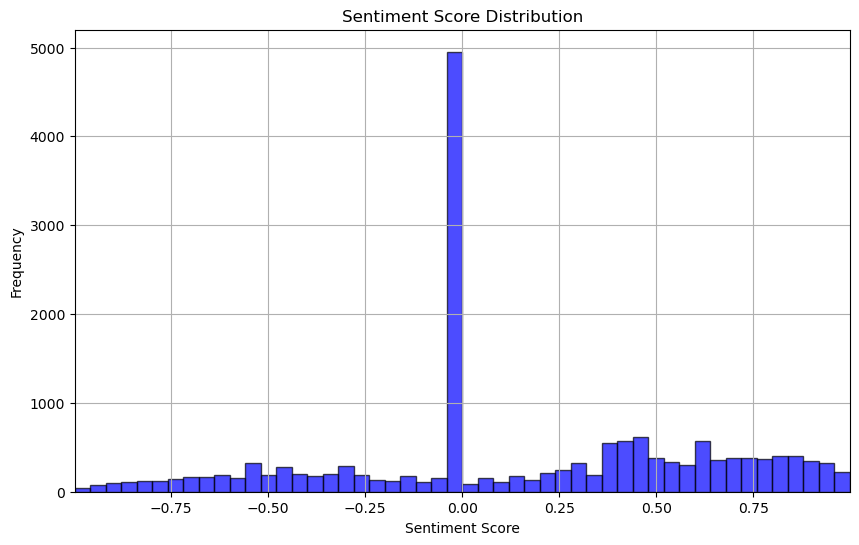

C:\Users\Saurabh Sharma\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


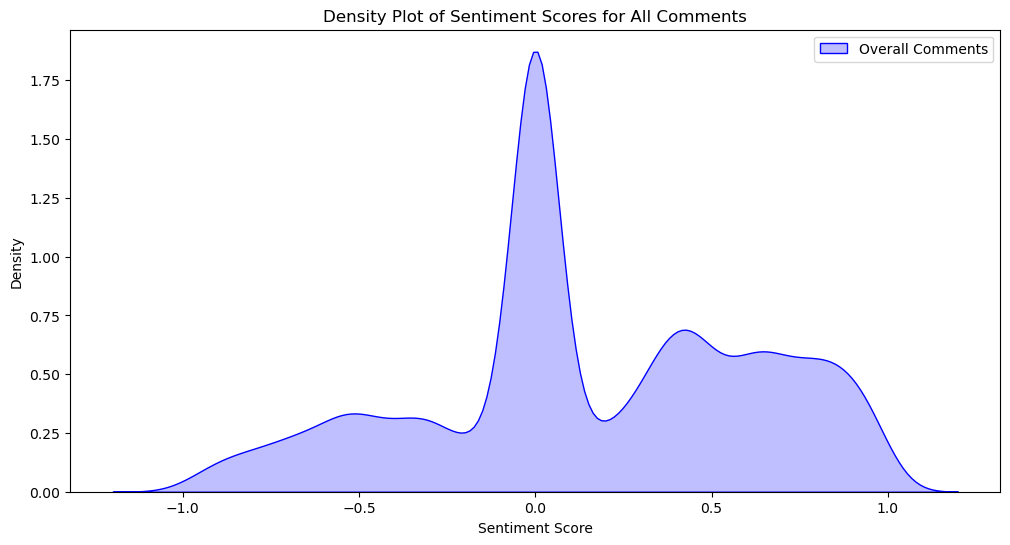

In [18]:
#Visualizing sentiment score distribution by histogram and density plot

num_bins = 50  # Number of bins

# Plotting sentiment score distribution
plt.figure(figsize=(10,6))
plt.hist(df['sentiment_score'], bins=num_bins, alpha=0.7, color='blue', edgecolor='black')
plt.grid(True)   # For better readability

# Setting plot titles and labels
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Score Distribution')

# Setting x and y limits
plt.xlim(df['sentiment_score'].min(), df['sentiment_score'].max())
plt.ylim(0, plt.ylim()[1])  # Ensuring y axis starts from 0 and is correclty scaled

plt.show()


# Plotting density of sentiment scores for all comments
import seaborn as sns
plt.figure(figsize=(12,6))
sns.kdeplot(df['sentiment_score'], fill=True, color='blue', label='Overall Comments')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.title('Density Plot of Sentiment Scores for All Comments')
plt.legend()
plt.show()

# Word Cloud for overall comments

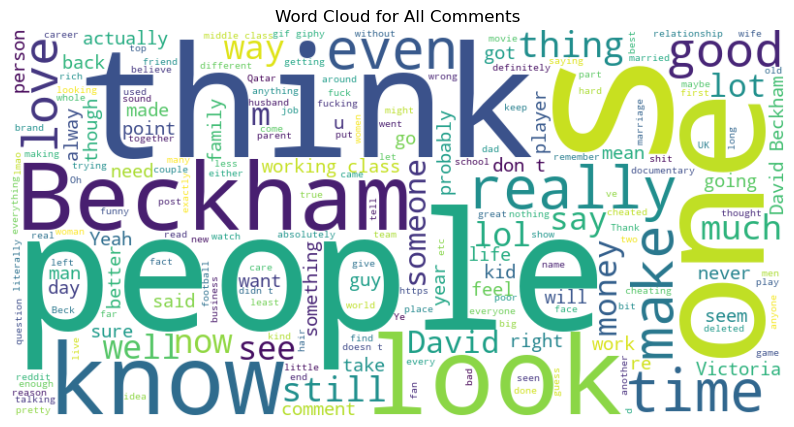

In [19]:
# Word Cloud for overall comments

from wordcloud import WordCloud, STOPWORDS
all_comments = ' '.join(df['Cleaned_Comments'])

# Generating word cloud with custom settings
wordcloud = WordCloud(
    width=800, height=400, background_color='white',
    stopwords=set(STOPWORDS), max_words=200, colormap='viridis'
).generate(all_comments)

# Displaying the word cloud
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels and ticks
plt.title('Word Cloud for All Comments')
plt.show()


## Topic Modelling

### Plotting coherence term plot to determine optimal number of topics

In [20]:
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
import numpy as np
# Extracting 'Cleaned_Comments' from the DataFrame
lPosts = df['Cleaned_Comments'].tolist()
data = [post.split() for post in lPosts]

# Create Dictionary and Corpus (this part remains the same)
id2word = corpora.Dictionary(data)
texts = data
corpus = [id2word.doc2bow(text) for text in texts]

# def compute_coherence_for_model(params):
#     """Compute coherence for a single model"""
#     num_topics, dictionary, corpus, texts = params
#     model = gensim.models.LdaModel(
#         corpus=corpus,
#         id2word=dictionary,
#         num_topics=num_topics,
#         random_state=100,
#         update_every=1,
#         chunksize=100,
#         passes=10,
#         alpha='auto',
#         per_word_topics=True
#     )
#     coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
#     return coherence_model.get_coherence()

# def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
#     """Compute coherence values for multiple models in parallel"""
#     pool = Pool(processes=cpu_count())
#     coherence_values = pool.map(
#         compute_coherence_for_model,
#         [(num_topics, dictionary, corpus, texts) for num_topics in range(start, limit, step)]
#     )
#     pool.close()
#     pool.join()
#     return coherence_values

# # Set parameters
# start, limit, step = 2, 40, 6

# # Compute coherence values
# coherence_values = compute_coherence_values(id2word, corpus, texts, start, limit, step)

# # Plot results
# x = range(start, limit, step)
# plt.figure(figsize=(12, 6))
# plt.plot(x, coherence_values, 'bo-')
# plt.xlabel("Number of Topics")
# plt.ylabel("Coherence Score")
# plt.title("Topic Coherence Scores by Number of Topics")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # Find optimal number of topics
# optimal_num_topics = x[np.argmax(coherence_values)]
# print(f'Optimal number of topics: {optimal_num_topics}')


In [21]:
topicNum = 5
wordNumToDisplay = 10
featureNum = 1500

## Performs counting via CountVectorizer and then apply the LDA model.

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

tfVectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=featureNum, stop_words='english')
tf = tfVectorizer.fit_transform(lPosts)
tfFeatureNames = tfVectorizer.get_feature_names_out()

ldaModel = LatentDirichletAllocation(n_components =topicNum, max_iter=10, learning_method='online').fit(tf)

### Visualising topics

In [23]:
# Define the display_topics function
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        for i in topic.argsort()[:-num_top_words - 1:-1]:
            print(f"{feature_names[i]} ({topic[i]:.4f})")
        print()

## Diplays discovered topics.

In [24]:
display_topics(ldaModel, tfFeatureNames, wordNumToDisplay)

Topic 0:
class (895.7881)
people (794.9610)
got (526.9638)
working (523.6063)
said (463.2505)
lol (430.6811)
rich (349.4429)
just (331.8321)
person (327.7518)
money (320.4109)

Topic 1:
like (2358.4318)
just (968.7074)
beckham (825.9733)
don (807.1090)
think (793.2329)
david (699.6460)
good (670.7644)
look (637.0829)
know (593.3981)
time (584.6625)

Topic 2:
did (664.1967)
love (646.8963)
didn (518.6308)
better (385.1493)
just (371.5365)
beckham (340.5673)
maybe (313.1364)
spice (288.5954)
wasn (286.9965)
old (264.4770)

Topic 3:
https (626.0936)
com (322.9480)
www (257.9957)
reddit (257.2446)
comment (229.9443)
gif (228.1199)
qatar (206.7739)
giphy (195.4600)
post (186.2257)
det (169.4393)

Topic 4:
people (540.8019)
lot (475.2137)
ve (353.1206)
way (334.3722)
just (333.7428)
best (329.8593)
need (321.5201)
don (313.2394)
think (311.7434)
great (303.2438)



In [25]:
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(ldaModel, tf, tfVectorizer, mds='tsne') # Use lda_model for prepare
pyLDAvis.display(panel)

# Network Analysis and Community Detection

In [28]:
import networkx as nx
from networkx.algorithms import community
from sklearn.metrics.pairwise import cosine_similarity
# Define a threshold for considering a document as related to a topic
threshold = 0.7  # Example value, adjust as needed
doc_topic_dist = ldaModel.transform(tf)
# Iterate over each topic
for topic_idx in range(ldaModel.n_components): # Use n_components instead of num_topics
    # Extract documents related to the current topic
    related_docs_indices = np.where(doc_topic_dist[:, topic_idx] > threshold)[0]
    related_docs = [lPosts[i] for i in related_docs_indices]

    # Print the related documents
    print(f"Documents related to Topic {topic_idx}:\n")
    for idx, doc in enumerate(related_docs):
        print(f"Document {idx + 1}: {doc}\n")

    # Perform community analysis
    # Step 1: Vectorize the related documents using TF-IDF
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(related_docs)

    # Step 2: Compute cosine similarity matrix
    cosine_sim_matrix = cosine_similarity(tfidf_matrix)

    # Step 3: Create a graph from the cosine similarity matrix
    G = nx.Graph()
    for i in range(len(related_docs)):
        for j in range(i + 1, len(related_docs)):
            if cosine_sim_matrix[i, j] > 0.5:  # Example threshold, adjust as needed
                G.add_edge(i, j, weight=cosine_sim_matrix[i, j])

# Step 4: Detect communities using the Girvan-Newman method
    communities_generator = community.girvan_newman(G) # Call girvan_newman directly from the community module
    top_level_communities = next(communities_generator)
    sorted_communities = sorted(map(sorted, top_level_communities))

# Print the communities
    print(f"Communities for Topic {topic_idx}:\n")
    for idx, community_list in enumerate(sorted_communities): # Renamed 'community' to 'community_list' to avoid name conflict
        print(f"Community {idx + 1}:")
        for doc_idx in community_list:
            print(f"Document {doc_idx + 1}: {related_docs[doc_idx]}")
        print("="*80)  # Separator between communities

    # Export the graph to a GEXF file for Gephi
    nx.write_gexf(G, f"reddit_document_similarity_graph_topic_{topic_idx}.gexf")

    

Documents related to Topic 0:

Document 1: its not our choice to be born poor or rich but lying about it is fucked up

Document 2: Rich people always have this sort of hard done by victim complex

“Working class” come off it ya Posh fuck

Document 3: I knew a rich girl in middle school who was claiming to be provided because for some reason it was cool to be poor. 
I first explained how her shoes that she was wearing alone were more valuable than my entire wardrobe, which somehow she didn't understand. So I got annoyed and said "oh, you said you are poor, I thought I heard you say your daddy drives a porche."
She said she's poor, her parents are rich... ish years ago, I'm still sure she's an idiot to today

Document 4: She’s simultaneously talking down on the “working class” while also trying to be proud of it. Such mental gymnastics for the super wealthy especially those born into it. They feel more validated if people think they had to work for their wealth I guess? Coming from a hou

Communities for Topic 1:

Community 1:
Document 4: He’s dealt with her shit a million times before
Document 325: You know he cheated on her like a million times?
Community 2:
Document 7: Bend it like Beckham
Document 50: There, they're and their, David! Get it right!
Document 99: Open on his side. She looks like she would do anything for him.
Document 102: Open relationship? How do you know their marriage is an open relationship?
Document 110: Celebrities. Just like us.
Document 150: Yeah, you're right.
Document 153: Yes, that is how it works.
Document 172: I really really really really want to play with my trains
Document 184: I don't know what it is, but something about the Beckham have never sat right with me
Document 207: "What he would look like."

not, "How he would look like."

Alternately, you can say, "How he would look."
Document 208: How David Beckham would look\* What David Beckham would look like\*
  
Bandit like Beckham
Document 212: That's the David Beckham we have at ho

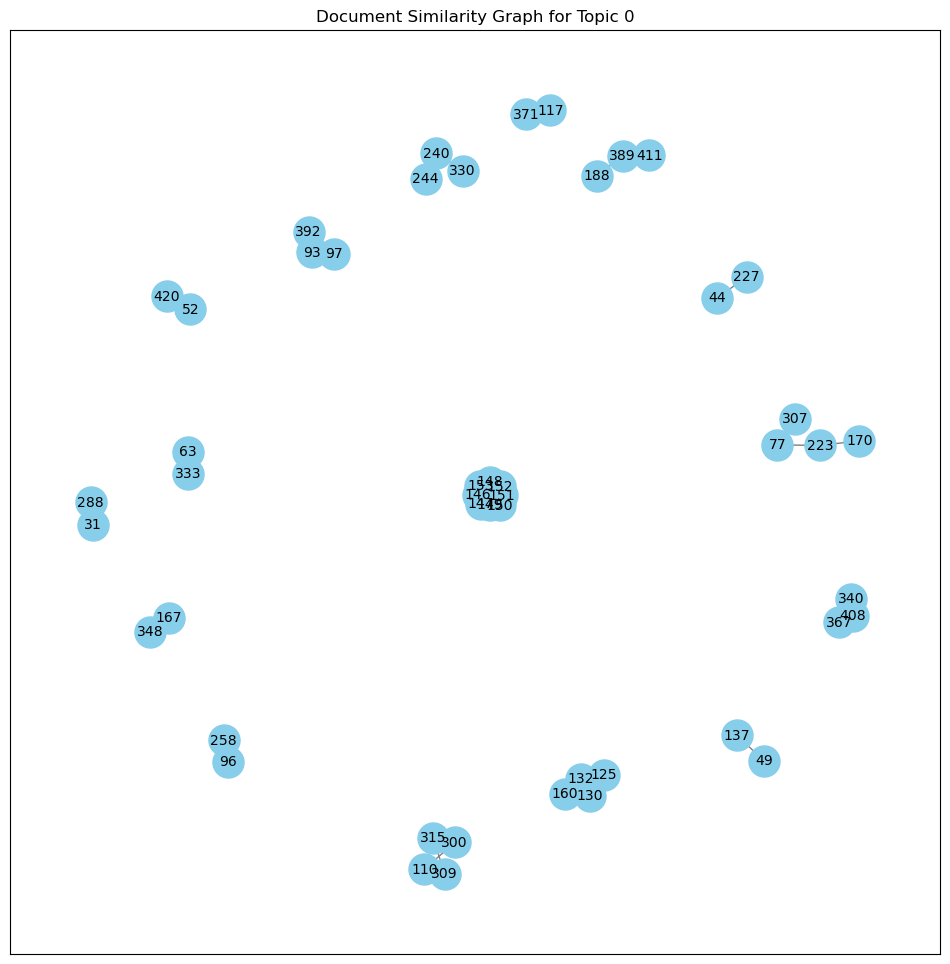

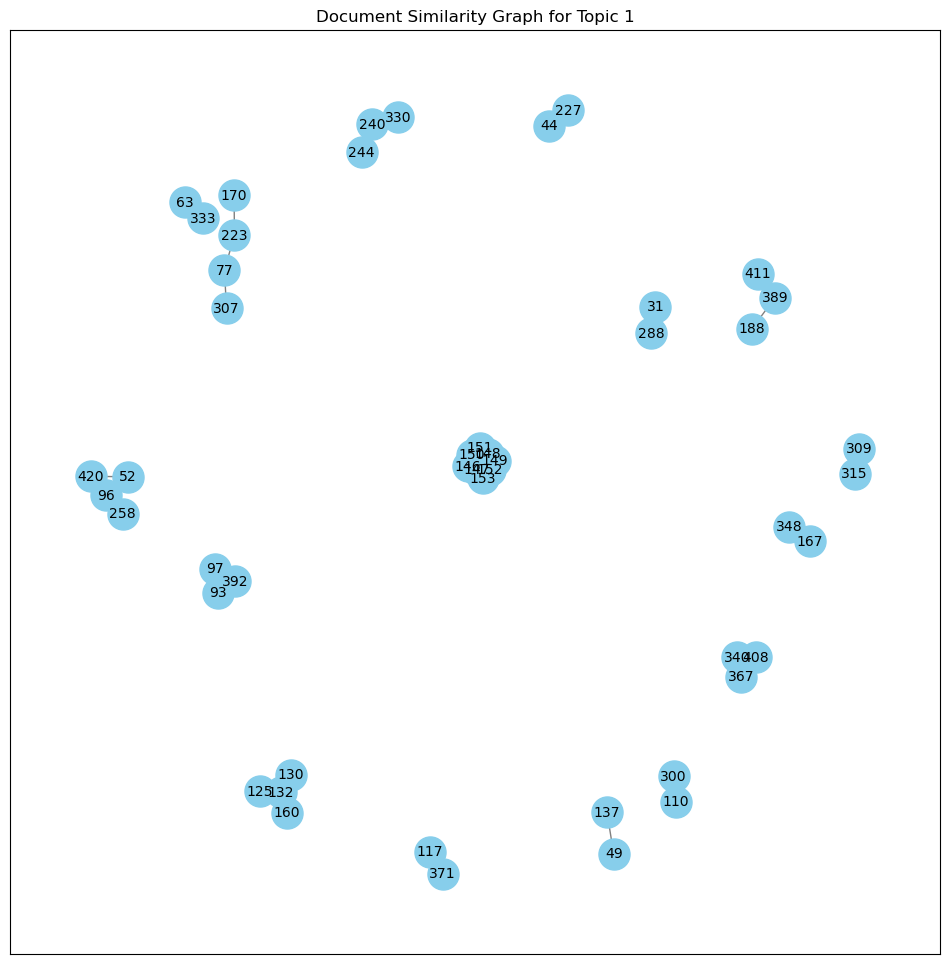

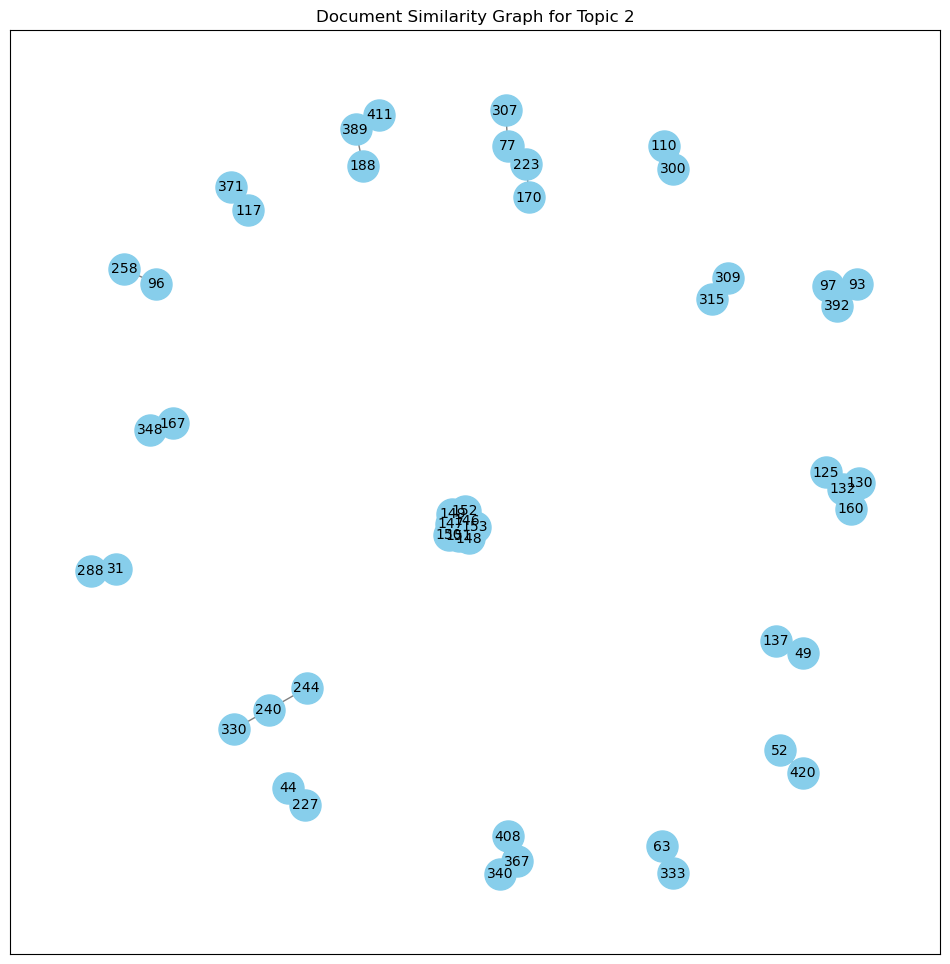

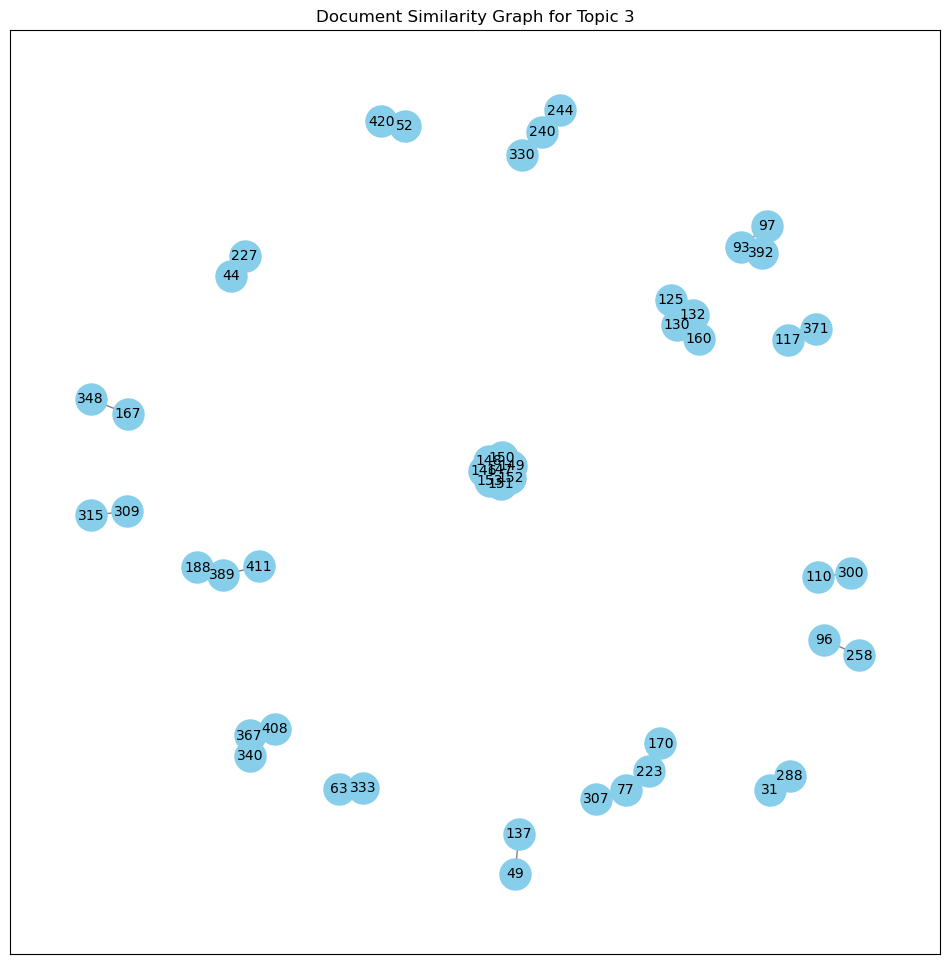

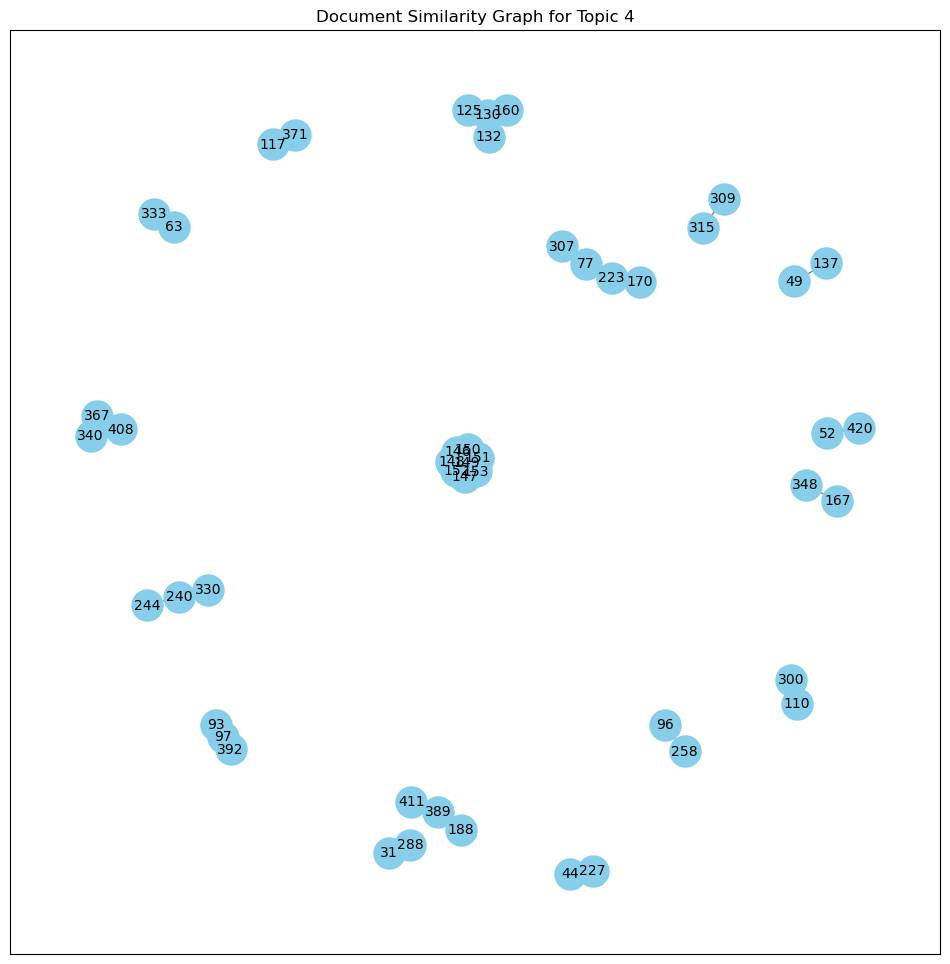

In [31]:
for topic_idx in range(ldaModel.n_components): 
    # Extract documents related to the current topic (as before)
    related_docs_indices = np.where(doc_topic_dist[:, topic_idx] > threshold)[0]
    related_docs = [lPosts[i] for i in related_docs_indices]


# Visualize the graph and save it as an image
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G)
    nx.draw_networkx(G, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=10, font_color="black", edge_color="gray")
    plt.title(f"Document Similarity Graph for Topic {topic_idx}")
    plt.savefig(f"reddit_document_similarity_graph_topic_{topic_idx}.png")  # Save the graph as an image
    plt.show()